# Read JSON files

do premennej `graphs_raw` sa nacitaju vsetky grafy z datasetu

`graph_raw`:
  - `filename`: nazov .lua suboru, z ktoreho je vytvoreny
  - `path`: cesta k .lua suboru, z ktoreho je vytvoreny 
  - `is_test`: 1 ak sa subor nachadzal v `test` adresari, inak 0
  - `is_spec`: 1 ak sa subor nachadzal v `spec` adresari, inak 0
  - `is_shebang`: 1 ak boli prve 2 znaky v subore '#!', inak 0
  - `nodes`: DataFrame(columns=\['id', 'type'\])
  - `edges`: DataFrame(columns=\['from', 'to'\])



In [573]:
import os
import pandas as pd
import json
from tqdm.notebook import tnrange # loading bar

In [574]:
graphs_raw = []

data_path = '../data'
dirs = os.listdir(data_path)
num_dirs = len(dirs)

for i in tnrange(num_dirs, desc='Dataset loading'):
    dirname = dirs[i]
    dir_path = data_path + '/' + dirname
    for filename in os.listdir(dir_path):
        json_file = dir_path + '/' + filename
        with open(json_file) as jf:
            graph = {}
            try:
                json_data = json.load(jf)
                graph['filename'] = json_data['_filename']
                graph['path'] = json_data['_path']
                graph['is_test'] = int(json_data['_isTest'])
                graph['is_spec'] = int(json_data['_isSpec'])
                graph['is_shebang'] = int(json_data['_isShebang'])
                graph['nodes'] = pd.DataFrame(json_data['nodes'], columns=['id', 'type'])
                graph['nodes'] = graph['nodes'].set_index('id')
                graph['edges'] = pd.DataFrame(json_data['edges'], columns=['from', 'to'])
                graphs_raw.append(graph)
            except:
                print(f'Wrong json file: {json_file}')

Dataset loading:   0%|          | 0/216 [00:00<?, ?it/s]

Wrong json file: ../data/cd/simpledraw.lua.json
Wrong json file: ../data/cd-examples/simpledraw.lua.json
Wrong json file: ../data/lrexlib/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-gnu/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-gnu/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-oniguruma/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-oniguruma/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-pcre/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-pcre/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-posix/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-posix/pcre_sets.lua.json
Wrong json file: ../data/lrexlib-tre/oniguruma_sets.lua.json
Wrong json file: ../data/lrexlib-tre/pcre_sets.lua.json
Wrong json file: ../data/lua-openssl/7.csr.lua.json
Wrong json file: ../data/lua-path/test_wcs.lua.json
Wrong json file: ../data/lua-pop3/test-message.lua.json
Wrong json file: ../dat

## Node types

Kedze extraktor, ktory som pouzil na extrakciu grafov zo zdrojovych lua suborov ma zopar bugov, v typoch uzlov sa nachadzaju aj take uzly, ktore by tam byt nemali.

In [439]:
unique_list = []
for d in graphs_raw:
    curr_list = d['nodes']['type'].unique()
    unique_list += list(set(curr_list) - set(unique_list))

In [440]:
print('Node types:')
for u in unique_list:
    print(f'    {u}')

Node types:
    statement:if
    blank lines
    statement:assign
    statement:while
    variable container
    function container
    statement:localassign
    require local variable
    statement:keyword
    module
    local variable
    require container
    interface
    global function
    n/a
    global variable
    function
    interface container
    file
    statement:functioncall
    statement:genericfor
    tableconstructor
    statement:numericfor
    string
    statement:localfunction
    table assign node
    unop
    number
    symbol
    boolean
    statement:repeat
    statement:globalfunction
    keyword
    statement:do
    _prefixexp
    _simpleexp


# OneHot

Kazdemu grafu z `graphs_raw` sa prida atribut `enc_node_types` (OneHot kodovanie typov uzlov).

- `enc_node_types` je DataFrame OneHot kodovani pre vsetky uzly v danom grafe
- **typy uzlov**: *\['require container', 'function', 'local variable', 'file', 'tableconstructor', 'module', 'statement:keyword', 'variable container', 'statement:numericfor', 'statement:genericfor', 'statement:if', 'global function', 'statement:functioncall', 'statement:assign', 'function container', 'statement:localassign', 'global variable', 'statement:globalfunction', 'statement:while', 'statement:localfunction', 'interface container', 'interface', 'require local variable', 'statement:do', 'statement:repeat'\]*
- ostatne typy uzlov sa ignoruju (taketo uzly budu zakodovane samymi nulami)

In [441]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [442]:
NODE_TYPES = [
    'require container', 'function', 'local variable', 'file', 
    'tableconstructor', 'module', 'statement:keyword', 
    'variable container', 'statement:numericfor', 'statement:genericfor', 
    'statement:if', 'global function', 'statement:functioncall', 
    'statement:assign', 'function container', 'statement:localassign', 
    'global variable', 'statement:globalfunction', 'statement:while', 
    'statement:localfunction', 'interface container', 'interface', 
    'require local variable', 'statement:do', 'statement:repeat'
]

enc = OneHotEncoder(handle_unknown='ignore')
X = np.array(NODE_TYPES).reshape(-1,1)
enc.fit(X)

for gr in graphs_raw:
    # encode all NodeTypes in graph
    encoded = enc.transform(gr['nodes']['type'].values.reshape(-1,1))
    gr['enc_node_types'] = pd.DataFrame(encoded.toarray())

In [443]:
graphs_raw[0]['enc_node_types']

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create dataset

dataset tvoria `graphs` a `graph_labels`
- `graphs` je numpy.Array of StellarGraphs
- `graph_labels` je numpy.Array oznaceni pre dany graf na i-tej pozcii
    - `basic` => 0
    - `is_shebang` => 1
    - `is_spec` => 2
  
Pozn.: do `basic` zdrojovych kodov su nakoniec zaradene aj `is_test` (obycajne testy), pretoze struktury ich extrahovanych grafov su velmi podobne

In [444]:
from stellargraph import StellarGraph

In [446]:
def createStellarGraph(graphRaw):
    nodes = graphRaw['enc_node_types']
    edges = graphRaw['edges']
    graph = StellarGraph(
            nodes=nodes,
            edges=edges,
            source_column='from',
            target_column='to',
            is_directed=True
        )
    return graph

graphs = np.array([createStellarGraph(gr) for gr in graphs_raw])
#graph_labels = pd.Series(
#        [
#            1 if gr['is_shebang']
#            else 2 if gr['is_spec']
#            else 3 if gr['is_test']
#            else 0 for gr in graphs_raw
#        ], 
#        dtype="category",
#        name='label'
#    )
graph_labels = np.array([
        1 if gr['is_shebang']
        else 2 if gr['is_spec']
        else 0 for gr in graphs_raw
    ])

# Dataset stats

Dataset je velmi nevyvazeny. Pocet `basic` zdrojovych kodov vysoko prevysuje pocty `Shebang` a `Spec` zdrojovych kodov

In [447]:
value_counts = pd.Series(graph_labels).value_counts()
basic_count = value_counts[0]
shebang_count= value_counts[1]
spec_count = value_counts[2]

print(f'''Label counts
    Basic: {basic_count}
    Shebang: {shebang_count}
    Specs: {spec_count}
    ''')

Label counts
    Basic: 2247
    Shebang: 131
    Specs: 114
    


In [448]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,2492.0,2492.0
mean,93.9,156.9
std,165.7,308.6
min,5.0,4.0
25%,20.0,24.0
50%,43.0,57.0
75%,100.0,153.0
max,2400.0,4300.0


# Outliers

Grafy s extremne nizkym (dolny 5% quantil) a s extremne vysokym (horny 5% quantil) poctom uzlov sa z datasetu odfiltruju.

In [449]:
lower = summary['nodes'].quantile(0.05)
upper = summary['nodes'].quantile(0.95)

print(f'''Nodes count quantiles:
    lower: {lower}
    upper: {upper}
    ''')

Nodes count quantiles:
    lower: 8.0
    upper: 341.0
    


In [450]:
clipped = summary.loc[(summary['nodes'] > lower) & (summary['nodes'] < upper)]

In [451]:
clipped.describe().round(1)

,nodes,edges
count,2239.0,2239.0
mean,68.2,109.6
std,65.9,138.7
min,9.0,8.0
25%,22.5,27.0
50%,43.0,57.0
75%,90.0,136.5
max,340.0,1960.0


In [452]:
graphs = pd.DataFrame(graphs).iloc[clipped.index].to_numpy().flatten()
graph_labels = pd.DataFrame(graph_labels).iloc[clipped.index].to_numpy().flatten()

In [453]:
value_counts = pd.Series(graph_labels).value_counts()
basic_count = value_counts[0]
shebang_count= value_counts[1]
spec_count = value_counts[2]

print(f'''Label counts
    Basic: {basic_count}
    Shebang: {shebang_count}
    Specs: {spec_count}
    ''')

Label counts
    Basic: 2026
    Shebang: 122
    Specs: 91
    


# Undersampling

Z `basic` zdrojovych kodov sa nahodne vyberie mensi pocet grafov ako ich je v skutocnosti, cim sa upravi ich pomer ku grafom ostatnych tried. 

Tymto krokom sa trochu vyvazi dataset.

In [454]:
from imblearn.under_sampling import RandomUnderSampler

In [455]:
u_samp_strategy = {
    0: 500,
    1: shebang_count,
    2: spec_count
}

undersample = RandomUnderSampler(sampling_strategy=u_samp_strategy, random_state=1)
graphs_under, graph_labels_under = undersample.fit_resample(graphs.reshape(-1, 1), graph_labels)

In [456]:
graphs = graphs_under.flatten()
graph_labels = graph_labels_under

# Final (sampled) dataset stats

In [457]:
print(graphs[0].info())

StellarGraph: Directed multigraph
 Nodes: 151, Edges: 200

 Node types:
  default: [151]
    Features: float32 vector, length 25
    Edge types: default-default->default

 Edge types:
    default-default->default: [200]
        Weights: all 1 (default)
        Features: none


In [458]:
value_counts = pd.Series(graph_labels).value_counts()
basic_count = value_counts[0]
shebang_count= value_counts[1]
spec_count = value_counts[2]

print(f'''Label counts
    Basic: {basic_count}
    Shebang: {shebang_count}
    Specs: {spec_count}
    ''')

Label counts
    Basic: 500
    Shebang: 122
    Specs: 91
    


In [459]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,713.0,713.0
mean,67.4,122.3
std,67.1,172.3
min,9.0,8.0
25%,22.0,27.0
50%,40.0,56.0
75%,87.0,145.0
max,337.0,1960.0


# Prepair generator
Z `graph_labels` sa vytvori OneHot encoding labelov. 

Pozn.: Generator je potrebny neskor na to, aby sa objekty typu `StellarGraph` mohli vkladat do modelu neuronovej siete z Tensorflow-u

In [460]:
from stellargraph.mapper import PaddedGraphGenerator

In [461]:
graph_labels = pd.get_dummies(graph_labels, drop_first=False)

print(graph_labels)

     0  1  2
0    1  0  0
1    1  0  0
2    1  0  0
3    1  0  0
4    1  0  0
..  .. .. ..
708  0  0  1
709  0  0  1
710  0  0  1
711  0  0  1
712  0  0  1

[713 rows x 3 columns]


In [462]:
num_graphs, num_classes = graph_labels.shape

print(f'Number of classes: {num_classes}\nNumber of graphs: {num_graphs}')

Number of classes: 3
Number of graphs: 713


In [463]:
generator = PaddedGraphGenerator(graphs=graphs)

# Supervised graph classification with GCN [StellarGraph]

In [464]:
import stellargraph as sg
from stellargraph.layer import GCNSupervisedGraphClassification
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
import kerastuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt

## Split dataset to TRAIN, VALIDATION and TEST
Pomer percent TRENOVACI\:VALIDACNY\:TESTOVACI == **70\:15\:15**

In [465]:
# TRAIN:TEST 85:15
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.85, stratify=graph_labels
)

# TRAIN:VALIDATION 82.4:17.6 => 85*0.824 == 70  85*0.176 == 15 
train_graphs, val_graphs = model_selection.train_test_split(
    train_graphs, train_size=0.824, stratify=train_graphs
)

In [466]:
print(f'TRAIN graphs: {len(train_graphs)}\nVALIDATION graphs: {len(val_graphs)}\nTEST graphs: {len(test_graphs)}')

TRAIN graphs: 499
VALIDATION graphs: 107
TEST graphs: 107


## Compute class weights
Kedze je dataset nevyrovnany, trebalo zvysit citlivost na minoritne triedy

In [467]:
y_integers = np.argmax(train_graphs.to_numpy(), axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

In [468]:
d_class_weights

{0: 0.47523809523809524, 1: 1.934108527131783, 2: 2.64021164021164}

## Create generators

In [469]:
batch_size=32

train_gen = generator.flow(
        train_graphs.index, targets=graph_labels.iloc[train_graphs.index].values, batch_size=batch_size
    )
val_gen = generator.flow(
        val_graphs.index, targets=graph_labels.iloc[val_graphs.index].values, batch_size=batch_size
    )

## Build model
- `GCNSupervisedGraphClassification` obsahuje grafove konvolucne vrstvy sluziace na extrakciu vlastnosti grafov a mean pooling vrstvu na znizenie dimenzionality dat
- `Dense` vrstvy sluzia na samotny proces klasifikacie

Funkciu je mozno pouzit aj pocas ladenia hyperparametrov pomocou `keras-tuner`

In [470]:
def model_builder(hp=None):
    # default hyperparameters
    convo1 = 64
    convo2 = 64
    dropout = 0.5
    dense1 = 32
    dense2 = 16
    learning_rate = 0.005
    
    # hyperparameter tuning
    if (hp):
        convo1 = hp.Int('convo1', min_value=32, max_value=320, step=32)
        convo2 = hp.Int('convo2', min_value=32, max_value=320, step=32)
        dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
        dense1 = hp.Int('dense1', min_value=32, max_value=320, step=32)
        dense2 = hp.Int('dense2', min_value=16, max_value=160, step=16)
        learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.005, 0.01])
    
    gc_model = GCNSupervisedGraphClassification(
            layer_sizes=[convo1, convo2],
            activations=["relu", "relu"],
            generator=generator,
            dropout=dropout,
        )

    x_inp, x_out = gc_model.in_out_tensors()
    
    predictions = Dense(units=dense1, activation="relu")(x_out)
    predictions = Dense(units=dense2, activation="relu")(predictions)
    predictions = Dense(num_classes, activation="softmax")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=categorical_crossentropy, metrics=['accuracy', Precision()])
    
    return model

In [471]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [472]:
model = model_builder()

## Tune hyperparameters

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='.',
                     project_name='tuner')

In [ ]:
tuner.search(train_gen, epochs=100, validation_data=val_gen, verbose=1, class_weight=d_class_weights, callbacks=[es])

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]

print(f'''Optional hyperparameters:
    convo1: {best_hps.get('convo1')}
    convo2: {best_hps.get('convo2')}
    dropout: {best_hps.get('dropout')}
    dense1: {best_hps.get('dense1')}
    dense2: {best_hps.get('dense2')}
    learning_rate: {best_hps.get('learning_rate')}
    ''')

In [44]:
model = tuner.hypermodel.build(best_hps)

## Train model

In [473]:
epochs = 100

In [474]:
history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        verbose=1,
        class_weight=d_class_weights,
        callbacks=[es],
    )

Epoch 1/100
16/16 [==============================] - 2s 71ms/step - loss: 1.0490 - accuracy: 0.3912 - precision_12: 0.0000e+00 - val_loss: 1.1350 - val_accuracy: 0.1495 - val_precision_12: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 1s 46ms/step - loss: 1.0147 - accuracy: 0.2959 - precision_12: 0.6587 - val_loss: 0.8785 - val_accuracy: 0.7757 - val_precision_12: 0.8182
Epoch 3/100
16/16 [==============================] - 1s 50ms/step - loss: 0.8586 - accuracy: 0.6377 - precision_12: 0.6440 - val_loss: 0.6501 - val_accuracy: 0.7944 - val_precision_12: 0.8690
Epoch 4/100
16/16 [==============================] - 1s 45ms/step - loss: 0.6664 - accuracy: 0.7371 - precision_12: 0.7898 - val_loss: 0.7011 - val_accuracy: 0.7196 - val_precision_12: 0.7889
Epoch 5/100
16/16 [==============================] - 1s 46ms/step - loss: 0.6898 - accuracy: 0.7123 - precision_12: 0.7485 - val_loss: 0.6958 - val_accuracy: 0.7196 - val_precision_12: 0.8072
Epoch 6/100
16/16 [=============

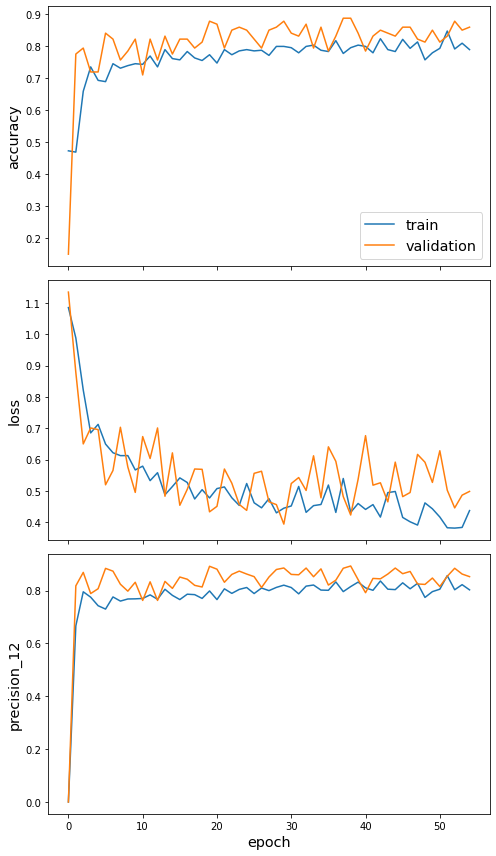

In [476]:
sg.utils.plot_history(history)

# Evaluate on test sample

In [477]:
test_gen = generator.flow(
        test_graphs.index, targets=graph_labels.iloc[test_graphs.index].values, batch_size=1
    )

In [576]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

107/107 [==============================] - 0s 3ms/step - loss: 0.3978 - accuracy: 0.8598 - precision_12: 0.8835

Test Set Metrics:
	loss: 0.3978
	accuracy: 0.8598
	precision_12: 0.8835


# Visualize predictions

In [512]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [513]:
predicts = model.predict(test_gen)
Y_pred = predicts.argmax(axis=1)
Y = graph_labels.iloc[test_graphs.index].values.argmax(axis=1)
cf_matrix = confusion_matrix(Y, Y_pred, normalize='true')

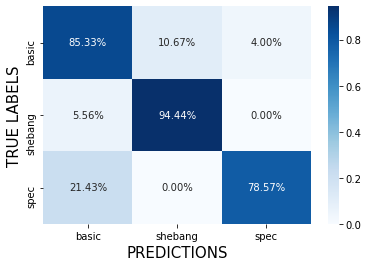

In [514]:
labels = ['basic', 'shebang', 'spec']
ax = sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('PREDICTIONS', fontsize = 15)
plt.ylabel('TRUE LABELS', fontsize = 15)

plt.show()

In [551]:
res = {}
res['basic'] = np.array([p for _, p in enumerate(predicts) if Y[_] == 0])
res['shebang'] = np.array([p for _, p in enumerate(predicts) if Y[_] == 1])
res['spec'] = np.array([p for _, p in enumerate(predicts) if Y[_] == 2])

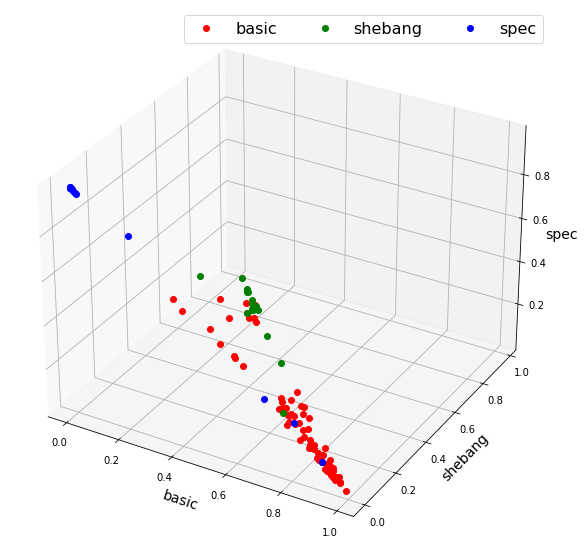

In [572]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))

ax = plt.subplot(projection='3d')

ax.plot(res["basic"][:,0], res["basic"][:,1], res["basic"][:,2], 'o', color='r', label='basic')
ax.plot(res["shebang"][:,0], res["shebang"][:,1], res["shebang"][:,2], 'o', color='g', label='shebang')
ax.plot(res["spec"][:,0], res["spec"][:,1], res["spec"][:,2], 'o', color='b', label='spec')

ax.set_xlabel('basic', fontsize=14)
ax.set_ylabel('shebang', fontsize=14)
ax.set_zlabel('spec', fontsize=14)

plt.legend(loc='upper right', ncol=3, fontsize=16)

plt.show()

# Save model to local storage

In [139]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets
